In [2]:
from yugiquery import *
header('Timeline')

<div align='center'>
    <br>
    <!-- Pre Style needed to fix HTML formatting -->
    <pre style="line-height: var(--jp-code-line-height); font-family: var(--jp-code-font-family)">
    ██    ██ ██    ██  ██████  ██  ██████  ██    ██ ███████ ██████  ██    ██ 
     ██  ██  ██    ██ ██       ██ ██    ██ ██    ██ ██      ██   ██  ██  ██  
      ████   ██    ██ ██   ███ ██ ██    ██ ██    ██ █████   ██████    ████   
       ██    ██    ██ ██    ██ ██ ██ ▄▄ ██ ██    ██ ██      ██   ██    ██    
       ██     ██████   ██████  ██  ██████   ██████  ███████ ██   ██    ██    
                                      ▀▀                                     
    </pre>
</div>
<div align='right'>
    Timeline - Execution started 22/02/2023 14:33 UTC <br>
    By <b>Guilherme Ruiz</b>
</div>

---

Table of Contents
=================

*   [1  Data preparation](#Data-preparation)
    *   [1.1  Load data](#Load-data)
    *   [1.2  Format data](#Format-data)
    *   [1.3  Merge data](#Merge-data)
*   [4  Data visualization](#Data-visualization)
    *   [4.1  First releases](#First-releases)
        *   [4.1.1  By region](#By-region)
    *   [4.1  Last releases](#Last-releases)
        *   [4.1.1  By region](#By-region)
    *   [4.2  All Releases](#All-Releases)
        *   [4.2.1  By card type](#By-card-type)
        *   [4.2.2  By primary type](#By-primary-type)
        *   [4.2.3  By secondary type](#By-secondary-type)
        *   [4.2.4  By attribute](#By-attribute)
        *   [4.2.5  By monster type](#By-monster-type)
        *   [4.2.6  By Level/Rank](#By-Level/Rank)
        *   [4.2.7  By ATK](#By-ATK)
        *   [4.2.8  By DEF](#By-DEF)
        *   [4.2.9  By pendulum scale](#By-pendulum-scale)
        *   [4.2.10  By link](#By-link)
*   [5  Debug](#Debug)
    *   [5.1  Merge failed](#Merge-failed)
*   [6  Epilogue](#Epilogue)
    *   [6.1  HTML export](#HTML-export)
<!-- *   [6.2  Git](#Git) -->

# Data preparation

## Load data

In [14]:
# Load list of important dates
with open('../assets/dates.json','r') as f:
    dates_json = json.load(f)
    anime_df = pd.DataFrame(dates_json['anime']['series']).set_index('title').applymap(pd.to_datetime, dayfirst=True)
    rules_df = pd.DataFrame(dates_json['rules']).set_index('title').applymap(pd.to_datetime, dayfirst=True).iloc[2:] # Ignore old rules

In [8]:
# Get list of files
all_cards_files = sorted(glob.glob('../data/all_cards_*.csv'), key=os.path.getctime, reverse=True)
all_speed_files = sorted(glob.glob('../data/all_speed_*.csv'), key=os.path.getctime, reverse=True)
set_lists_files = sorted(glob.glob('../data/all_sets_*.csv'), key=os.path.getctime, reverse=True)
# Get newest file if exist
if len(all_cards_files)>0:
    all_cards_df = pd.read_csv(all_cards_files[0], dtype=object)
    # Correct tuples
    all_cards_df['Secondary type'] = all_cards_df['Secondary type'].dropna().apply(literal_eval)
    all_cards_df['Effect type'] = all_cards_df['Effect type'].dropna().apply(literal_eval)
    all_cards_df['Link Arrows'] = all_cards_df['Link Arrows'].dropna().apply(literal_eval)
    all_cards_df['Archseries'] = all_cards_df['Archseries'].dropna().apply(literal_eval)
    all_cards_df['Artwork'] = all_cards_df['Artwork'].dropna().apply(literal_eval)
    all_cards_df['Errata'] = all_cards_df['Errata'].dropna().apply(literal_eval)
    print('Cards file loaded')
else:
    all_cards_df = None
    print('No cards files')
    
if len(all_speed_files)>0:
    all_speed_df = pd.read_csv(all_speed_files[0], dtype=object)
    # Correct tuples
    all_speed_df['Secondary type'] = all_speed_df['Secondary type'].dropna().apply(literal_eval)
    all_speed_df['Effect type'] = all_speed_df['Effect type'].dropna().apply(literal_eval)
    all_speed_df['Archseries'] = all_speed_df['Archseries'].dropna().apply(literal_eval)
    all_speed_df['Artwork'] = all_speed_df['Artwork'].dropna().apply(literal_eval)
    # all_speed_df['Errata'] = all_speed_df['Errata'].dropna().apply(literal_eval)
    print('Speed duel cards file loaded')
else:
    all_cards_df = None
    print('No speed duel files')
    
if len(set_lists_files)>0:
    set_lists_df = pd.read_csv(set_lists_files[0], dtype=object)
    # Correct tuples
    set_lists_df['Rarity'] = set_lists_df['Rarity'].dropna().apply(literal_eval)
    set_lists_df['Cover card'] = set_lists_df['Cover card'].dropna().apply(literal_eval)
    print('Sets file loaded')
else:
    set_lists_df = None
    print('No set lists files')

Cards file loaded
Speed duel cards file loaded
Sets file loaded


## Format data

In [9]:
if all_cards_df is not None and all_speed_df is not None and set_lists_df is not None:
    all_cards_df['index'] = all_cards_df['Name'].str.lower()
    all_speed_df['index'] = all_speed_df['Name'].str.lower()
    set_lists_df['index'] = set_lists_df['Name'].str.lower()
    all_cards_df['Modification date'] = pd.to_datetime(all_cards_df['Modification date'])
    all_speed_df['Modification date'] = pd.to_datetime(all_speed_df['Modification date'])
    set_lists_df['Modification date'] = pd.to_datetime(set_lists_df['Modification date'])
    set_lists_df['Release'] = pd.to_datetime(set_lists_df['Release'])
    
else:
    raise SystemExit("Not enough files to proceed. Aborting!")

## Merge data

In [10]:
full_df = pd.concat([all_cards_df, all_speed_df]).drop_duplicates(ignore_index=True)
full_df = full_df.merge(set_lists_df, indicator = True, how='outer', on='index')
full_df = full_df.convert_dtypes()
full_df['Modification date'] = full_df[['Modification date_x','Modification date_y']].max(axis=1)
full_df['Name'] = full_df['Name_x'].fillna(full_df['Name_y'])
full_df.drop(['index', 'Name_x', 'Name_y', 'Modification date_x', 'Modification date_y'], axis=1, inplace = True)
full_df.rename(columns={'Page URL_x': 'Card page URL', 'Page URL_y': 'Set page URL'}, inplace=True)
full_df = full_df[np.append(full_df.columns[-1:],full_df.columns[:-1])]

# Data visualization

In [ ]:
full_df

## First releases

Obs: Only the first release of an individual card name

In [11]:
first_release=full_df[full_df['Release'].notna()].groupby('Name')['Release'].agg(['min','idxmin'])
first_release

,min,idxmin
Name,,
"""A Legendary Ocean""",2005-07-27,320702
"""A"" Cell Breeding Device",2007-02-15,6
"""A"" Cell Incubator",2007-07-21,16
"""A"" Cell Recombination Device",2016-07-09,25
"""A"" Cell Scatter Burst",2006-11-16,32
...,...,...
Zubaba Knight,2011-03-19,319902
Zubababancho Gagagacoat,2019-11-09,319925
Zuijin of the Ice Barrier,2020-11-21,319934


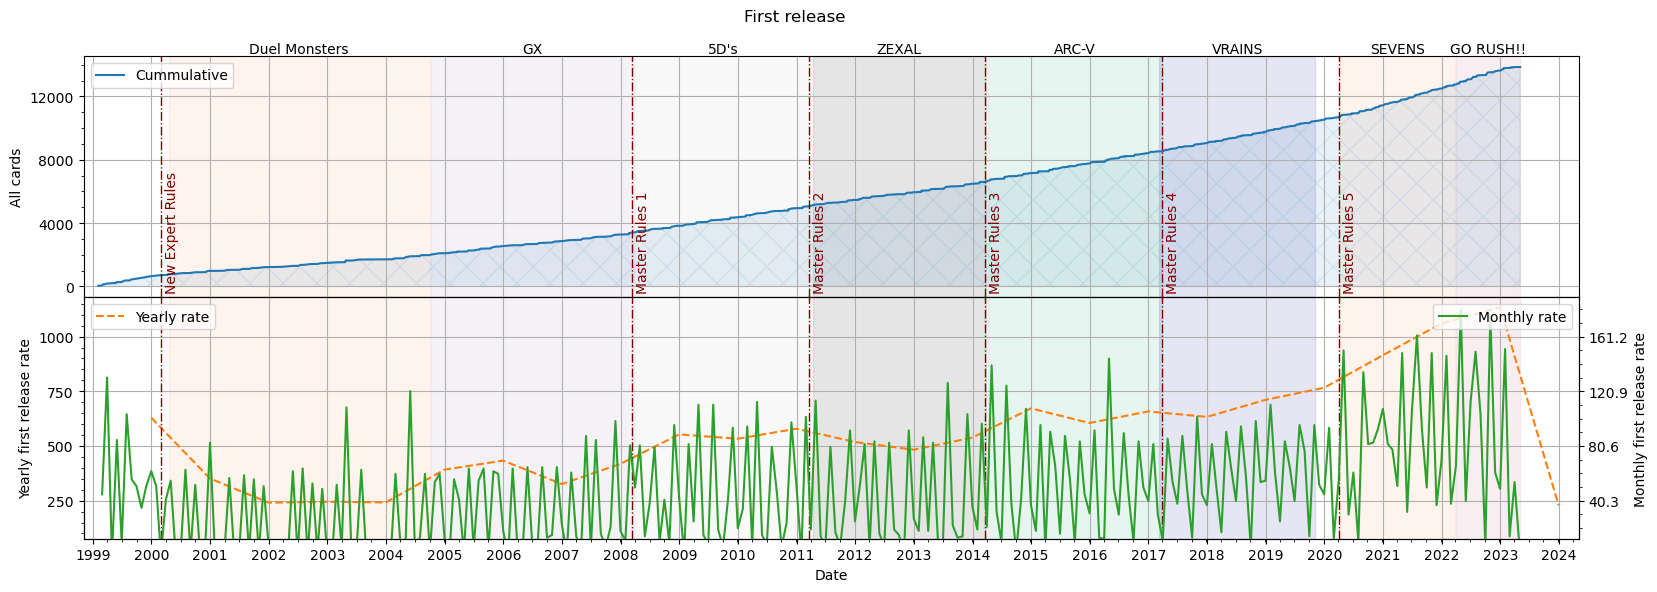

In [12]:
first_release_count = first_release['min'].sort_values().value_counts(sort=False).to_frame(name='All cards')
first_release_count.index.name = 'First Release'
rate_plot(first_release_count, bg=anime_df, vlines = rules_df['begin'])


### By region

In [ ]:
first_release_region=full_df[full_df['Release'].notna()].groupby(['Region','Name'])['Release'].agg(['min','idxmin'])
first_release_region

In [ ]:
first_release_region_count = first_release_region['min'].sort_values().groupby(['Region']).value_counts(sort=False).unstack(0).fillna(0).round(0)
first_release_region_count.index.name = 'Release'
rate_subplots(first_release_region_count, title = 'First Release', bg=anime_df, vlines = rules_df['begin'])

## Last releases

Obs: Only the last release of an individual card name

In [ ]:
last_release=full_df[full_df['Release'].notna()].groupby('Name')['Release'].agg(['max','idxmax'])
last_release

In [ ]:
last_release_count = last_release['max'].sort_values().value_counts(sort=False).to_frame(name='All cards')
last_release_count.index.name = 'Last Release'
rate_plot(last_release_count, bg=anime_df, vlines = rules_df['begin'])

### By region

In [ ]:
last_release_region=full_df[full_df['Release'].notna()].groupby(['Region','Name'])['Release'].agg(['max','idxmax'])
last_release_region

In [ ]:
last_release_region_count = last_release_region['max'].sort_values().groupby(['Region']).value_counts(sort=False).unstack(0).fillna(0).round(0)
last_release_region_count.index.name = 'Release'
rate_subplots(last_release_region_count, title = 'Last Release', bg=anime_df, vlines = rules_df['begin'])

## All Releases

Obs: All releases includes reprints

### By card type

In [ ]:
# All releases, includes reprints - Double check
release_card_type = full_df.groupby(['Card type','Release'])['Name'].nunique().unstack(0).sort_index().fillna(0).astype(int)
release_card_type.groupby(release_card_type.index.strftime('%Y')).sum().T

In [ ]:
# card_type_colors = [colors_dict[col] for col in release_card_type.columns]
# rate_subplots(release_card_type, colors=card_type_colors, bg=anime_df, vlines = rules_df['begin'])

In [ ]:
card_type_colors = [colors_dict[col] for col in release_card_type.columns]
rate_plot(release_card_type, colors=card_type_colors, bg=anime_df, vlines = rules_df['begin'])

### By primary type

In [ ]:
# All releases, includes reprints - Double check
# Sort properly
release_primary_type = full_df.groupby(['Primary type','Release'])['Name'].nunique().unstack(0).sort_index().fillna(0).astype(int)
release_primary_type.groupby(release_primary_type.index.strftime('%Y')).sum().T

In [ ]:
# primary_type_colors = [colors_dict[col] for col in release_primary_type.columns]
# rate_subplots(release_primary_type, colors=primary_type_colors, bg=anime_df, vlines=rules_df['begin'])

In [ ]:
primary_type_colors = [colors_dict[col] for col in release_primary_type.columns]
rate_plot(release_primary_type, colors=primary_type_colors, bg=anime_df, vlines = rules_df['begin'])

### By secondary type

In [ ]:
# All releases, includes reprints - Double check
# Sort properly
release_secondary_type = full_df.groupby(['Secondary type','Release'])['Name'].nunique().unstack(0).sort_index().fillna(0).astype(int)
release_secondary_type.groupby(release_secondary_type.index.strftime('%Y')).sum().T

In [ ]:
# rate_subplots(release_secondary_type, bg=anime_df, vlines = rules_df['begin'])

In [ ]:
rate_plot(release_secondary_type, bg=anime_df, vlines = rules_df['begin'])

### By attribute

In [ ]:
# All releases, includes reprints - Double check
# Sort properly
release_attribute = full_df.groupby(['Attribute','Release'])['Name'].nunique().unstack(0).sort_index().fillna(0).astype(int)
release_attribute.groupby(release_attribute.index.strftime('%Y')).sum().T

In [ ]:
# attribute_colors = [colors_dict[col] for col in release_attribute.columns]
# rate_subplots(release_attribute, colors=attribute_colors, bg=anime_df, vlines = rules_df['begin'])

In [ ]:
attribute_colors = [colors_dict[col] for col in release_attribute.columns]
rate_plot(release_attribute, colors = attribute_colors, bg=anime_df, vlines = rules_df['begin'], cumsum=True)

### By monster type

In [ ]:
# All releases, includes reprints - Double check
# Sort properly
release_monster_type = full_df.groupby(['Monster type','Release'])['Name'].nunique().unstack(0).sort_index().fillna(0).astype(int)
release_monster_type.groupby(release_monster_type.index.strftime('%Y')).sum().T

In [ ]:
rate_subplots(release_monster_type, bg=anime_df, vlines = rules_df['begin'])

### By Level/Rank

In [ ]:
# Testing
def boxplot(df):
    col = df.columns[0]
    df['Year'] = df.index.strftime('%Y')
    df.dropna(inplace=True)

    ax = df.boxplot(by='Year', figsize=(16,10))

    mean = df.groupby('Year').mean()

    ax.plot(list(range(1,len(mean.index)+1)), mean.values, c='r', ls='--', alpha=0.5)
    
    ticks = np.arange(0,df[col].max()+1,1)
    if len(ticks)>15:
        ax.yaxis.set_major_locator(MaxNLocator(11, integer=True))
        ax.yaxis.set_minor_locator(AutoMinorLocator())
    else:
        ax.yaxis.set_major_locator(FixedLocator(ticks))
        
    # ax.set_ylim([0,5000])
    plt.tight_layout()
    plt.show()

In [ ]:
level_box = pd.to_numeric(full_df.set_index('Release')['Level/Rank'], errors='coerce').to_frame().sort_index().dropna()
boxplot(level_box)

### By ATK

In [ ]:
atk_box = pd.to_numeric(full_df.set_index('Release')['ATK'], errors='coerce').to_frame().sort_index().dropna()
boxplot(atk_box)

### By DEF

In [ ]:
def_box = pd.to_numeric(full_df.set_index('Release')['DEF'], errors='coerce').to_frame().sort_index().dropna()
boxplot(def_box)

### By pendulum scale

In [ ]:
pendulum_box = pd.to_numeric(full_df.set_index('Release')['Pendulum Scale'], errors='coerce').to_frame().sort_index().dropna()
boxplot(pendulum_box)

### By link

In [ ]:
link_box = pd.to_numeric(full_df.set_index('Release')['Link'], errors='coerce').to_frame().sort_index().dropna()
boxplot(link_box)

# Debug

## Merge failed

In [ ]:
full_df['_merge'].value_counts()

In [ ]:
full_df.where(full_df['_merge']=='right_only').dropna(axis=0,how='all')

In [ ]:
full_df.where(full_df['_merge']=='left_only').dropna(axis=0,how='all')

 # Epilogue

In [ ]:
footer()

## HTML export

In [ ]:
# May need to sleep for a few seconds after saving
save_notebook()

In [ ]:
! jupyter nbconvert Timeline.ipynb --output-dir='../' --to=HTML --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_cell_tags='exclude' --TemplateExporter.exclude_input=True --TemplateExporter.exclude_input_prompt=True --TemplateExporter.exclude_output_prompt=True

## Git

In [ ]:
! git add "../*[Tt]imeline*"

In [ ]:
! git commit -m {"'Timeline update-" + pd.Timestamp.now().strftime("%d%m%Y")+"'"}